In [43]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import cantera as ct

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from src.data import H2_combustion1
from src.edmd import TruncEDMD
from src.kernels import RBFKernel,ComplexKernel,PolynomialKernel,PeriodicLinearKernel,SigmoidKernel
from src.training_edmd import GD_edmd_training
from src.visualizations import  dynamicscombust,gridsearch,gridsearchnorm,traininglandscapenorm,OOS_system_normalize
from matplotlib.legend_handler import HandlerTuple

In [46]:

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Define the Dynamic System

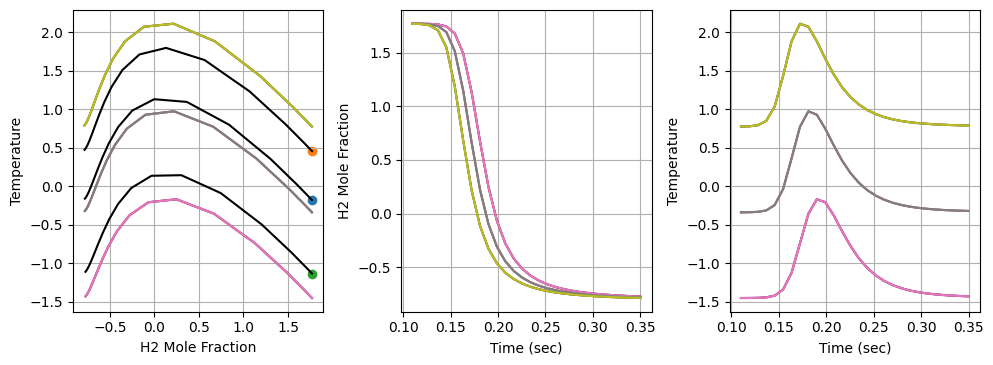

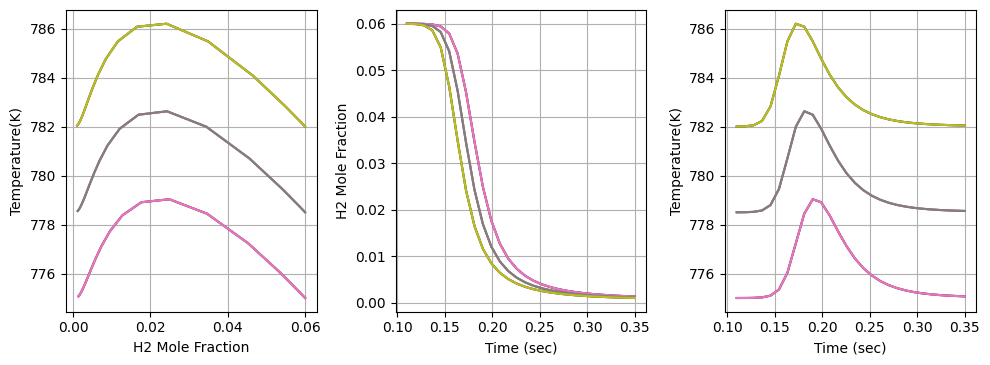

In [48]:
dynamic_system="non_steady_state_H2_single"
f, ax = plt.subplots(1, 3, figsize=(10, 3.75))
f1, ax1 = plt.subplots(1, 3, figsize=(10, 3.75))

#define dynamic system here for all tests

timesteps=160
factor=4
t_end=0.35#0.0006
t_begin=0.11
initial_conditions= np.array(np.meshgrid(np.linspace(0.06,0.06,3), np.linspace(775, 782,3))).T.reshape(-1, 2)
initial_conditions_sample=np.array([[0.06,779],[0.06,781],[0.06,776]])
t_eval=np.linspace(0, t_end, timesteps) #normal trajectory here

x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(H2_combustion1,initial_conditions,t_end,timesteps,factor,t_begin)
timesteps=len(t_eval_frac)



for ic, condition in enumerate(initial_conditions_norm):
    
    ax[0].plot(original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 1],)
    
    ax[1].plot(t_eval_frac,original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax[2].plot(t_eval_frac,original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 1])
    ax1[0].plot(original[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original[ic*(timesteps):ic*(timesteps)+(timesteps), 1],)
    ax1[1].plot(t_eval_frac,original[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax1[2].plot(t_eval_frac,original[ic*(timesteps):ic*(timesteps)+(timesteps), 1])

for ic,condition in enumerate(initial_conditions_sample):
     
        #t_eval=np.linspace(0, t_end, timesteps) #normal trajectory here
        dynamics_norm,initial_condition_norm_sample=OOS_system_normalize(t_eval,condition,original,H2_combustion1)
        int_begin=int(t_begin//(t_end/timesteps)) #change here!!!!!
        dynamics_norm=dynamics_norm[int_begin::factor]

        initial_condition_norm_sample=np.array([initial_condition_norm_sample],ndmin=2)
        #predicted=method.single_tradjectory(t_eval_frac,initial_condition_norm_sample.T,x.T,y.T,kernel,Kernel_results) 
        #sumloss = sumloss+np.sqrt(np.sum(np.square((abs(predicted-dynamics_norm))))/len(t_eval_frac))
        ax[0].plot(dynamics_norm[:,0],dynamics_norm[:,1],0.1,c="black", label="Original" )  
        ax[0].scatter(initial_condition_norm_sample[:,0],initial_condition_norm_sample[:,1])
                      

ax[0].grid()
ax[0].set_xlabel("H2 Mole Fraction")
ax[0].set_ylabel("Temperature")


ax[1].grid()
ax[1].set_xlabel("Time (sec)")
ax[1].set_ylabel("H2 Mole Fraction")

ax[2].grid()
ax[2].set_xlabel("Time (sec)")
ax[2].set_ylabel("Temperature")

ax1[0].grid()
ax1[0].set_xlabel("H2 Mole Fraction")
ax1[0].set_ylabel("Temperature(K)")
#ax[0].set_ylim(775,790)

ax1[1].grid()
ax1[1].set_xlabel("Time (sec)")
ax1[1].set_ylabel("H2 Mole Fraction")

ax1[2].grid()
ax1[2].set_xlabel("Time (sec)")
ax1[2].set_ylabel("Temperature(K)")



f.tight_layout()
f1.tight_layout()



Initialize all Kernels tested and results storage Note! keep factors aka #timesteps the same for all tests

In [49]:
timesteps=160
t_end=0.35#0.0006
t_begin=0.11
truncs = [np.array([None]) for _ in range(5)]
method = TruncEDMD()
parameters=[np.array([None]) for _ in range(5)]
kernels=[RBFKernel,ComplexKernel,PolynomialKernel,SigmoidKernel,PeriodicLinearKernel]
factors=np.array([4]) #stays constant for all tests Do not change
min_list=[np.array([None]) for _ in range(5)]


Run grid search for RBF Kernel (one kernel Parameter)

In [51]:


RBFparameters =np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5])#np.array([0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0])
RBFtruncs=np.array([20,25,30,35,40,45,50,55,60])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])


kernel = RBFKernel

truncs[0]=RBFtruncs
parameters[0]=RBFparameters

lossperstepRBF,OOSlossperstepRBF,optimRBF=gridsearchnorm(factors,RBFtruncs,RBFparameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)

Run Grid serach for Complex Kernel (one kernel parameter)

In [58]:

complexparameters =np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5])#np.array([0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0])
complextruncs=np.array([5,10,15,20,25,30,35,40])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])

kernel = ComplexKernel

truncs[1]=complextruncs
parameters[1]=complexparameters

lossperstepComplex,OOSlossperstepComplex,optimComplex=gridsearchnorm(factors,complextruncs,complexparameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)

Run grid search for Polynomial Kernel (no kernel paramters)

In [67]:

polyparameters = np.array([]) #define as empty array if no kernel paramters
polytruncs=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])

kernel = PolynomialKernel


truncs[2]=polytruncs
parameters[2]=polyparameters


lossperstepPoly,OOSlossperstepPoly,optimPoly=gridsearchnorm(factors,polytruncs,polyparameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)


Run grid search for Sigmoid Kernel (2 Kernel Parameters)

In [69]:

sigparam1=np.linspace(0.1,1.0,5)
sigparam2=np.linspace(0.1, 5.0,5)
sigparameters = np.array(np.meshgrid(sigparam1, sigparam2)).T.reshape(-1, 2)

sigtruncs=np.array([10,15,20,25,30,35,40])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])

kernel = SigmoidKernel


truncs[3]=sigtruncs
parameters[3]=sigparameters


lossperstepsig,OOSlossperstepsig,optimsig=gridsearchnorm(factors,sigtruncs,sigparameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)


Run grid search for PeriodicLinear Kernel (2 Kernel Parameters)

In [56]:

plparam1=np.linspace(0.1,5.0,5)
plparam2=np.linspace(0.1,5.0,5)
plparameters = np.array(np.meshgrid(plparam1, plparam2)).T.reshape(-1, 2)

pltruncs=np.array([10,15,20,25,30,35,40])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])
kernel = PeriodicLinearKernel


truncs[4]=pltruncs
parameters[4]=plparameters


losspersteppl,OOSlosspersteppl,optimpl=gridsearchnorm(factors,pltruncs,plparameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)

Visualize grid search results and find best parameter settings for each test

RBF min (array([1], dtype=int64), array([0], dtype=int64)) 0.538114339413704
Complex min (array([6], dtype=int64), array([2], dtype=int64)) 0.41033840770727986
poly min (array([0], dtype=int64), array([10], dtype=int64)) 0.4630558126810118
sig min [None] nan
pl min (array([23], dtype=int64), array([1], dtype=int64)) 5.423369195331053


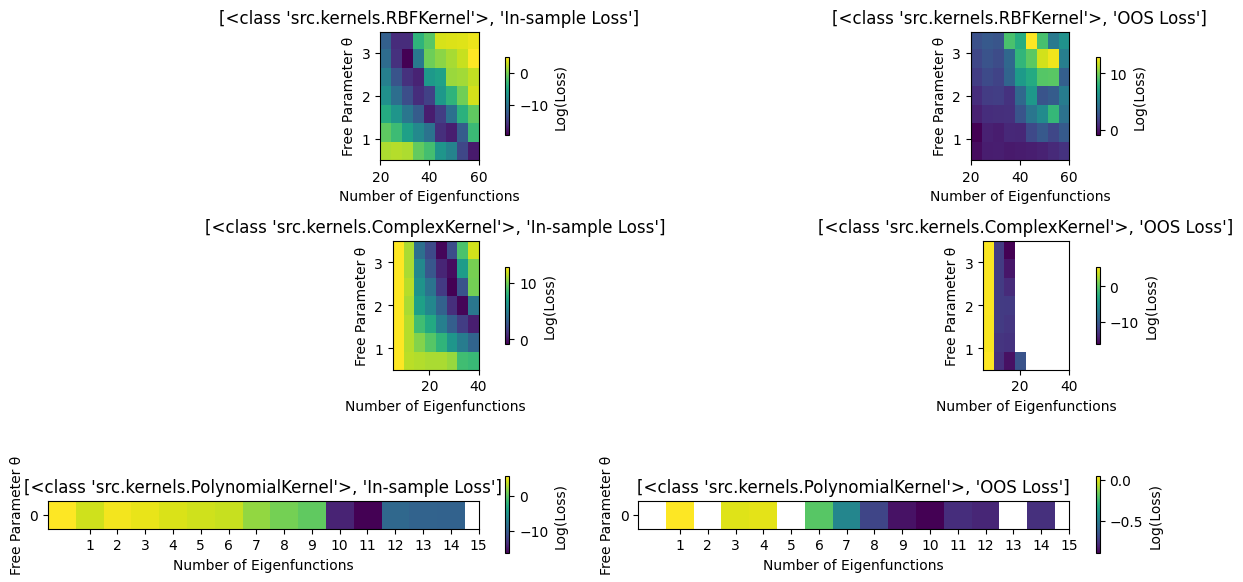

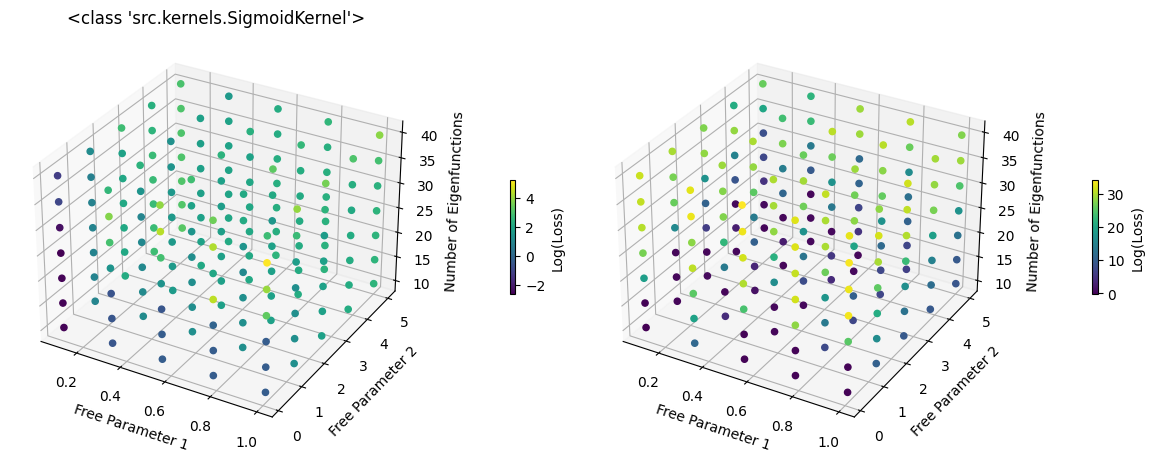

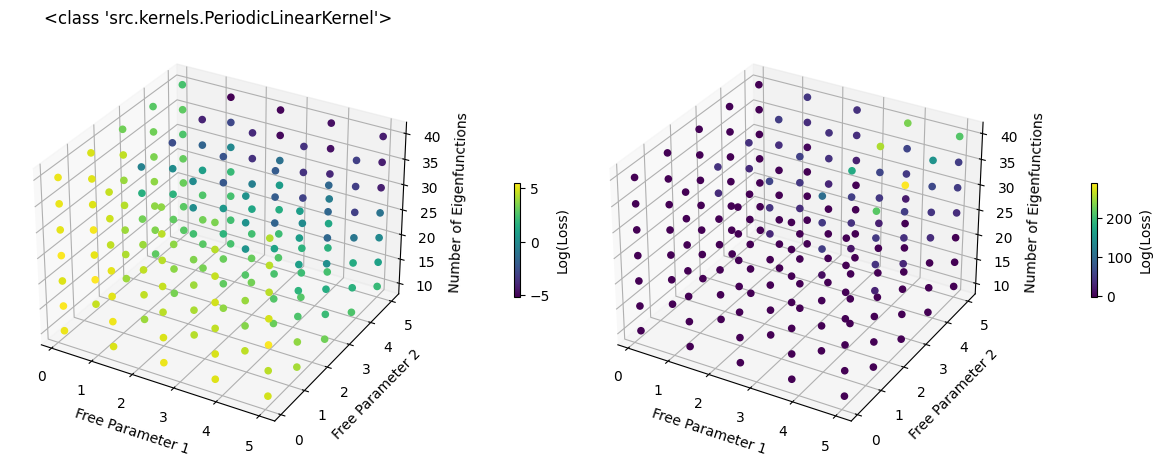

In [82]:
fig, ax = plt.subplots(3, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots

im=[]
## The best paramter combination affected by upper limit of OOSLoss as defined in visulaizations.py
###### RBF
im.append(ax[0,0].imshow(np.log(lossperstepRBF), extent=[np.min(RBFtruncs), np.max(RBFtruncs), np.min(RBFparameters), np.max(RBFparameters)], aspect=17.5, origin="lower"))
im.append(ax[0,1].imshow(np.log(OOSlossperstepRBF), extent=[np.min(RBFtruncs), np.max(RBFtruncs),np.min(RBFparameters), np.max(RBFparameters)], aspect=17.5, origin="lower"))
if np.isnan(np.nanmin(optimRBF)):
    min_list[0]=np.array([None])
else:
    min_list[0]=np.where(optimRBF== np.nanmin(optimRBF))
print("RBF min",min_list[0], np.nanmin(optimRBF))

######Complex
im.append(ax[1,0].imshow(np.log(lossperstepComplex), extent=[np.min(complextruncs), np.max(complextruncs), np.min(complexparameters), np.max(complexparameters)], aspect=17.5, origin="lower"))
im.append(ax[1,1].imshow(np.log(OOSlossperstepComplex), extent=[np.min(complextruncs), np.max(complextruncs),np.min(complexparameters), np.max(complexparameters)], aspect=17.5, origin="lower"))

if np.isnan(np.nanmin(optimComplex)):
    min_list[1]=np.array([None])
else:
    min_list[1]=np.where(optimComplex== np.nanmin(optimComplex))
print("Complex min",min_list[1], np.nanmin(optimComplex))

##Polynomial
im.append(ax[2,0].imshow(np.log(lossperstepPoly),  origin="lower"))
im.append(ax[2,1].imshow(np.log(OOSlossperstepPoly),  origin="lower"))
ax[2,0].set_yticks([0])
ax[2,1].set_yticks([0])
ax[2,0].set_xticks(polytruncs)
ax[2,1].set_xticks(polytruncs)
if np.isnan(np.nanmin(optimPoly)):
    min_list[2]=np.array([None])
else:
    min_list[2]=np.where(optimPoly== np.nanmin(optimPoly))
print("poly min",min_list[2], np.nanmin(optimPoly))

##### Plot aestetics for RBF, Complex
for i in range(0,3):
    
    cbar1 = fig.colorbar(im[i], ax=ax[i,0],shrink=0.6,)
    cbar1.set_label("Log(Loss)")
    cbar2 = fig.colorbar(im[i+1], ax=ax[i,1],shrink=0.6,)
    cbar2.set_label("Log(Loss)")

    ax[i, 0].set_title('Plot 1')
    ax[i,0].set_xlabel("Number of Eigenfunctions")
    ax[i,0].set_ylabel("Free Parameter θ")
    ax[i,0].set_title([kernels[i],"In-sample Loss"])  

    ax[i,1].set_xlabel("Number of Eigenfunctions")
    ax[i,1].set_ylabel("Free Parameter θ")
    ax[i,1].set_title([kernels[i],"OOS Loss"]) 

##### Sigmoid
fig = plt.figure(figsize= (12,6))
ax2, ax3 = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x,y,z=np.meshgrid(sigparam1,sigparam2,sigtruncs)
img=ax2.scatter(x, y,z,c=np.log(lossperstepsig), alpha=1)
img2=ax3.scatter(x, y,z,c=np.log(OOSlossperstepsig), alpha=1)
ax2.set_xlabel('Free Parameter 1')
ax2.set_ylabel('Free Parameter 2')
ax2.set_zlabel('Number of Eigenfunctions')
ax2.set_title(kernels[3])
cbar2 = plt.colorbar(img, ax=ax2, shrink=0.2, location="right", pad=0.15)
cbar2.set_label("Log(Loss)")
cbar3 = plt.colorbar(img2, ax=ax3, shrink=0.2, location="right", pad=0.15)
cbar3.set_label("Log(Loss)")
ax3.set_xlabel('Free Parameter 1')
ax3.set_ylabel('Free Parameter 2')
ax3.set_zlabel('Number of Eigenfunctions')

if np.isnan(np.nanmin(optimsig)):
    min_list[3]=np.array([None])
else:
    min_list[3]=np.where(optimsig== np.nanmin(optimsig))
print("sig min",min_list[3], np.nanmin(optimsig))

##### PeriodicLinear
fig = plt.figure(figsize= (12,6))
ax2, ax3 = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x,y,z=np.meshgrid(plparam1,plparam2,pltruncs)
img=ax2.scatter(x, y,z,c=np.log(losspersteppl), alpha=1)
img2=ax3.scatter(x, y,z,c=np.log(OOSlosspersteppl), alpha=1)
ax2.set_xlabel('Free Parameter 1')
ax2.set_ylabel('Free Parameter 2')
ax2.set_zlabel('Number of Eigenfunctions')
ax2.set_title(kernels[4])
cbar2 = plt.colorbar(img, ax=ax2, shrink=0.2, location="right", pad=0.15)
cbar2.set_label("Log(Loss)")
cbar3 = plt.colorbar(img2, ax=ax3, shrink=0.2, location="right", pad=0.15)
cbar3.set_label("Log(Loss)")
ax3.set_xlabel('Free Parameter 1')
ax3.set_ylabel('Free Parameter 2')
ax3.set_zlabel('Number of Eigenfunctions')

if np.isnan(np.nanmin(optimpl)):
    min_list[4]=np.array([None])
else:
    min_list[4]=np.where(optimpl== np.nanmin(optimpl))
print("pl min",min_list[4], np.nanmin(optimpl))



plt.tight_layout()

# Show the plot
plt.show()

Plot the best results from each test 

No Results for <class 'src.kernels.SigmoidKernel'>
loss tensor(5.3823, dtype=torch.float64, grad_fn=<AddBackward0>)


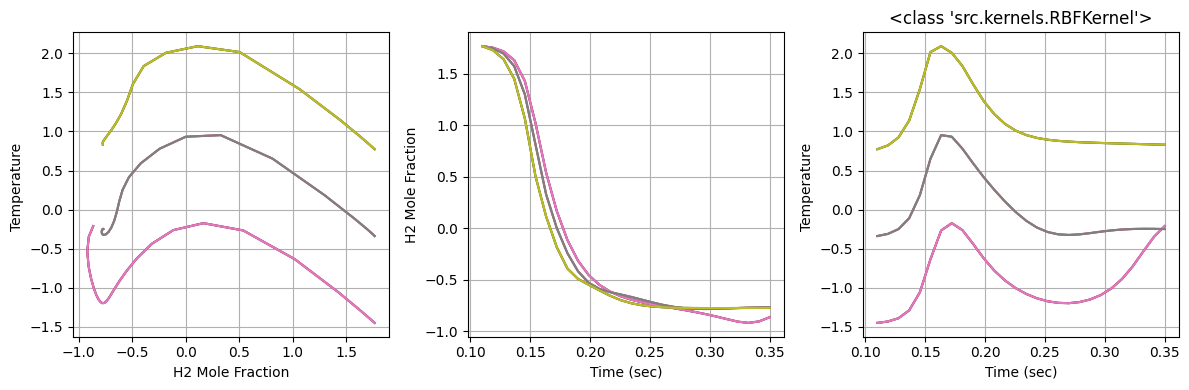

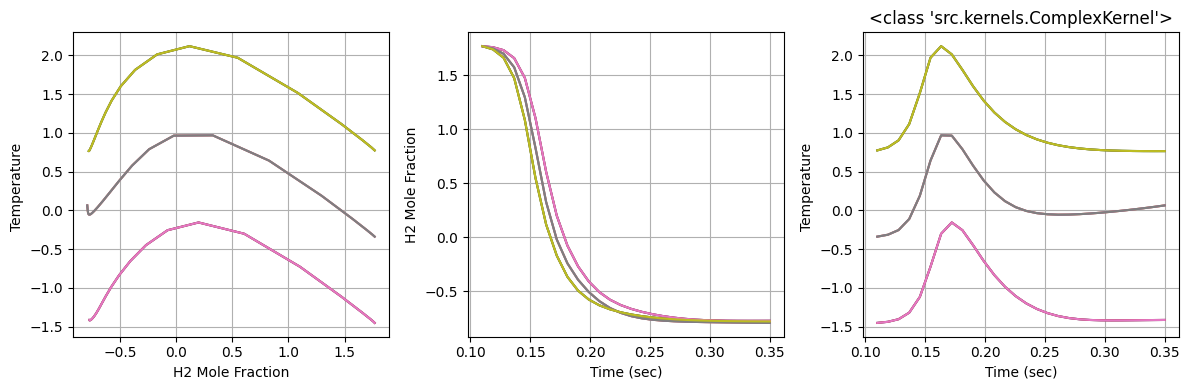

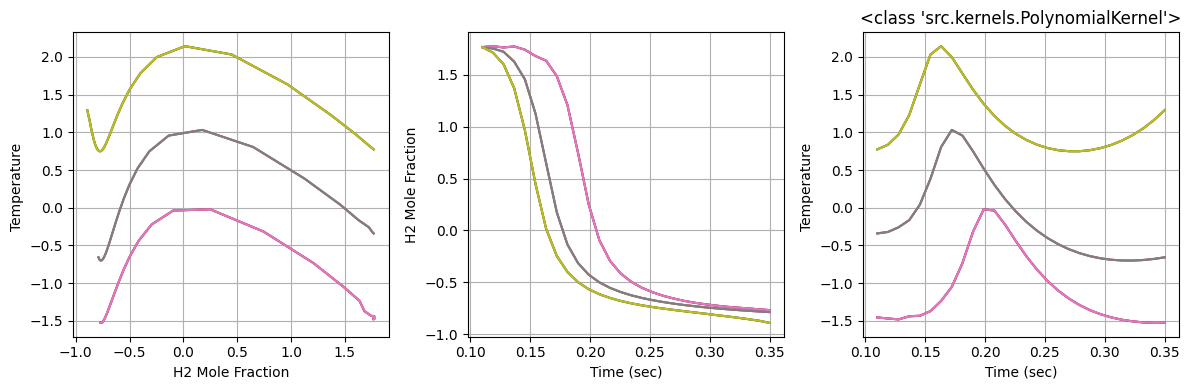

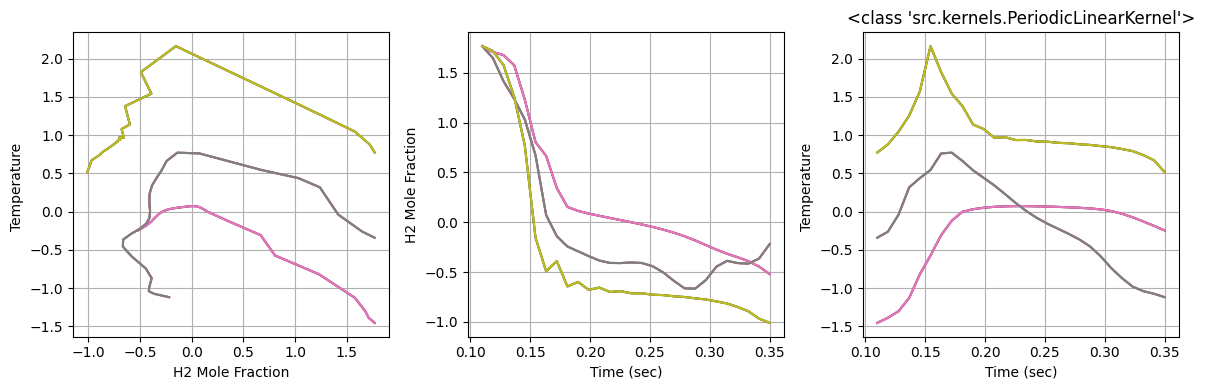

In [83]:

#print(min_list[4][0])
for i,k in enumerate(kernels):

    if min_list[i][0] is None:
        print("No Results for",k)
        continue
        
    truncset=truncs[i]
    
    trunc=int(truncset[min_list[i][1]])
    
    x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(H2_combustion1,
                                                    initial_conditions,t_end,timesteps,factor,t_begin)
  
    parameterset=parameters[i]
   
    if parameters[i].size==0:
        kernel = k()
    elif parameters[i].ndim==2:   
        parameterset=parameters[i][min_list[i][0]]
        parameter=[torch.tensor(float(parameterset[:,0]),requires_grad=True),torch.tensor(float(parameterset[:,1]),requires_grad=True)] 
        kernel = k(parameter)
    else:
        parameter=torch.tensor(float(parameterset[min_list[i][0]]),requires_grad=True) 
        kernel = k([parameter])
    Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)
    method.preloss_computation_full()
    loss = method.loss_full(kernel, x.T, y.T, penalty=True)
    f, ax = plt.subplots(1, 3, figsize=(12, 4))

    for ic,condition in enumerate(initial_conditions_norm):

        condition=np.array([condition],ndmin=2)
        Fx=method.single_tradjectory(t_eval_frac,condition.T,x.T,y.T,kernel,Kernel_results) 
   
        ax[0].plot(Fx[:,0],Fx[:,1])
        ax[0].set_xlabel("H2 Mole Fraction")
        ax[0].set_ylabel("Temperature ")
        ax[0].grid()
       
        ax[1].plot(t_eval_frac,Fx[:,0],)
        ax[1].set_xlabel("Time (sec)")
        ax[1].set_ylabel("H2 Mole Fraction")
        ax[1].grid()
        ax[2].plot(t_eval_frac,Fx[:,1],)
        ax[2].set_xlabel("Time (sec)")
        ax[2].set_ylabel("Temperature ")
        ax[2].grid()
    plt.title(k)
   
    f.tight_layout()
print("loss",loss)